In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
import numpy.matlib as npm

In [3]:
def rgb2gray(rgb):    
    r,g,b = rgb[:,:,:,0],rgb[:,:, :,1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [4]:
def get_image_and_label_in_folder(folder, images, labels):
    labels_dict = {'airplane':0, 'automobile':1, 'bird':2, 'cat': 3}

    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            labels.append(labels_dict[folder.split("/")[-1]])
    return images, labels

In [5]:
def sigmoid(z):
    try:
        res = 1 / (1 + math.exp(-z))
    except:
        res = 0
    return res

In [6]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

In [27]:
class NeuralNetwork:
    def __init__(self):

        ## Initializing three weights and biases randomly
        w1 = np.random.randn(16, 1024)
        w2 = np.random.randn(16, 16)
        w3 = np.random.randn(4, 16)
        w = [w1, w2, w3]

        b1 = np.zeros((16, 1))
        b2 = np.zeros((16, 1))
        b3 = np.zeros((4, 1))
        b = [b1, b2, b3]

        self.weights = w
        self.biases = b
        self.number_of_epochs = 10
        self.batch_size = 16
        self.learning_rate = 0.3
        self.number_of_samples = 200
        self.der = np.vectorize(sigmoid_derivative)

    def feedForward(self, data):
        z1 = (self.weights[0] @ data[0]) + self.biases[0]
        a1 = np.asarray([sigmoid(z[0]) for z in z1]).reshape((16, 1))
        z2 = (self.weights[1] @ a1) + self.biases[1]
        a2 = np.asarray([sigmoid(z[0]) for z in z2]).reshape((16, 1))
        z3 = (self.weights[2] @ a2) + self.biases[2]
        a3 = np.asarray([sigmoid(z[0]) for z in z3]).reshape((4, 1))
        return [a1, a2, a3], [z1, z2, z3]

    
    def calculateAccuracy(self, data):
        correct_guesses = 0
        for image in range(self.number_of_samples):
            guess = np.argmax(self.feedForward(data=data[image])[0][-1])
            if guess == np.argmax(data[image][1]):
                correct_guesses += 1  
            else:
                correct_guesses
        print("CORRECT GUESSES: ",correct_guesses)
        print("ACCURACY: ",correct_guesses / self.number_of_samples)
        return correct_guesses / self.number_of_samples

    def backPropagation(self, grad_w, grad_b, grad_a,  a, z, img):

        grad_w[2] += (self.der(z[2]) * (2 * a[2] - 2 * np.reshape(img[1],(4,1)))) @ (np.reshape((np.transpose(a[1])),(1,16)))
        grad_b[2] += (self.der(z[2]) * (2 * a[2] - 2 * np.reshape(img[1],(4,1))))

        grad_a[1] += np.transpose(self.weights[2]) @ (self.der(z[2]) * (2 * a[2] - 2 *np.reshape(img[1],(4,1))))
        grad_w[1] += (self.der(z[1]) * a[0]) @ (np.transpose(a[1]))
        grad_b[1] += (self.der(z[1]) * grad_a[1])

        grad_a[0] += np.transpose(self.weights[1]) @ (self.der(z[1]) * grad_a[1])
        ##print(np.shape(self.der(z[0])))
        grad_w[0] += (self.der(z[0] @ grad_a[0]) ) @ np.reshape(np.transpose(img[0]),(1,1024))
        ##print(np.shape(self.der(z[0])))
        grad_b[0] += (self.der(z[0]) @ grad_a[0])

        return grad_w, grad_b, grad_a

    def set_epoch(self,z):
        self.number_of_epochs = z

    def set_sample(self,z):
        self.number_of_samples = z


    def train(self, data):
        errors = []
        accuracy = []
        for i in range(self.number_of_epochs):
            epoch_cost = 0
            np.random.shuffle(data)

            batch_count = 0
            for j in range(0, self.number_of_samples, self.batch_size):
                batch_count += 1
                batch = data[j:j + self.batch_size] 

                grad_w3 = np.zeros((4, 16))
                grad_w2 = np.zeros((16, 16))
                grad_w1 = np.zeros((16, 1024))
                grad_w = [grad_w1, grad_w2, grad_w3]

                grad_b1 = np.zeros((16, 1))
                grad_b2 = np.zeros((16, 1))
                grad_b3 = np.zeros((4, 1))
                grad_b = [grad_b1, grad_b2, grad_b3]

                grad_a1 = np.zeros((16, 1))
                grad_a2 = np.zeros((16, 1))
                grad_a3 = np.zeros((4, 1))
                grad_a = [grad_a1, grad_a2, grad_a3]

                img_index = 0
                for img in batch:
                    # for img in batch:
                    print('\r\tEPOCH: %02d/%02d\t\tBATCH: %03d/%03d\t\tIMAGE: %04d/%04d\t\t' % (i + 1, self.number_of_epochs, batch_count, self.number_of_samples // self.batch_size, img_index+1, self.batch_size), end='')
                    a, z = self.feedForward(img)
                    grad_w, grad_b, grad_a = self.backPropagation(grad_w, grad_b, grad_a,  a, z, img)

                    #print("A, Z", a, z)

                    c = 0
                    for x in range(4):
                        print(np.reshape(img[1],(4,1))[x, 0])
                        c += (np.reshape(img[1],(4,1))[x, 0] - a[2][x, 0]) ** 2
                    epoch_cost += c

                    # x = img[1] - a[2]
                    # c = np.dot(x.T, x)
                    # epoch_cost += c[0][0]

                    img_index += 1

                for x in range(3):
                    self.weights[x] = self.weights[x] - (grad_w[x] / self.batch_size) * self.learning_rate
                    self.biases[x] =  self.biases[x] - (grad_b[x] / self.batch_size) * self.learning_rate

            errors.append(epoch_cost / self.number_of_samples)

            accuracy.append(self.calculateAccuracy(data))
            print('EPOCH COMPLETED!')
        plt.clf()
        plt.plot(errors, 'g')
        plt.xlabel("Epoch", color='white')
        plt.ylabel("Error", color='white')
        plt.grid(color='gray', linestyle='--', linewidth=0.5)

        plt.show()
        return errors


In [8]:
test_data = []
test_labels = []
category = ['airplane', 'automobile', 'bird', 'cat']

for c in category:
    print (c)
    test_data, test_labels = get_image_and_label_in_folder(r'/content/CIFAR/test/{}'.format(c),test_data,test_labels)
 

airplane
automobile
bird
cat


In [12]:
print (np.shape(test_data))
test_data_matrix = np.reshape(test_data, (4000,32,32,3))
test_data_gray_matrix = rgb2gray(test_data_matrix)
test_labels = np.array(test_labels)
# one-hot test labels
test_labels_matrix = np.zeros((test_labels.size,test_labels.max() + 1))
test_labels_matrix[np.arange(test_labels.size),test_labels] = 1

# flating test_data_matrix
test_data_gray_matrix = np.reshape(test_data_gray_matrix,(-1,1024))
# normalizing
normalized_test = []
for t in test_data_gray_matrix:
    normalized_test.append(t/255)

train_data = []
train_labels = []
for c in category:
    train_data, train_labels = get_image_and_label_in_folder(r'/content/CIFAR/train/{}'.format(c),train_data, train_labels)

train_data_matrix = np.reshape(train_data, (20000,32,32,3))
train_data_gray_matrix = rgb2gray(train_data_matrix)
train_labels = np.array(train_labels)
# one-hot train labels
train_labels_matrix = np.zeros((train_labels.size,test_labels.max() + 1))
train_labels_matrix[np.arange(train_labels.size),train_labels] = 1

train_data_gray_matrix = np.reshape(train_data_gray_matrix,(-1,1024))
# normalizing
normalized_train = []
for t in train_data_gray_matrix:
    normalized_train.append(t/255)

# print(np.shape(normalized_train))
# print(np.shape(train_labels_matrix))
train_data_set = list(zip(normalized_train, train_labels_matrix))
##random.shuffle(train_data_set)
normalized_train[:], train_labels_matrix[:] = zip(*train_data_set)
test_data_set = list(zip(normalized_test, test_labels_matrix))

# t_d_s = train_data_set

# fig, axes = plt.subplots(1, 5)
# fig.set_size_inches(10, 2) 

# print(np.shape(train_labels_matrix))

# i  = 0 
# for ax in range(0,20000,5000):
#     i+=1
#     print(train_labels_matrix[ax])
#     image = normalized_train[ax].reshape((32, 32))
#     axes[i].set_title('LABEL = {}'.format(np.argmax(train_labels_matrix[ax])))
#     axes[i].imshow(image, 'gray')
# plt.show()

(4000, 32, 32, 3)


In [26]:
nn = NeuralNetwork()

nn.set_epoch(10)
nn.set_sample(200)
##ffResult = nn.feedForward(train_data_set)
##np.random.shuffle(train_data_set)
nn.calculateAccuracy(train_data_set)

CORRECT GUESSES:  49
ACCURACY:  0.245


0.245

In [42]:
nn.set_epoch(20)
errors = []
for i in range(10):
    errors.append(nn.train(train_data_set))

errors = [(sum(z)/len(z)) for z in errors]
plt.clf()
plt.plot(errors, 'g')
plt.xlabel("Epoch", color='white')
plt.ylabel("Error", color='white')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

Streaming output truncated to the last 5000 lines.
1.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0005/0016		0.0
1.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0006/0016		0.0
0.0
1.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0007/0016		1.0
0.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0008/0016		0.0
1.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0009/0016		0.0
1.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0010/0016		1.0
0.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0011/0016		0.0
1.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0012/0016		0.0
0.0
1.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0013/0016		1.0
0.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0014/0016		1.0
0.0
0.0
0.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0015/0016		0.0
0.0
0.0
1.0
	EPOCH: 18/20		BATCH: 138/250		IMAGE: 0016/0016		0.0
0.0
0.0
1.0
	EPOCH: 18/20		BATCH: 139/250		IMAGE: 0001/0016		0.0
1.0
0.0
0.0
	EPOCH: 18/20		BATCH: 139/250		IMAGE: 0002/0016		0.0
0.0
1.0
0.0
	EPOCH: 18/20		BATCH: 139/250		

KeyboardInterrupt: ignored

	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0001/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0002/0016		0.0
0.0
0.0
1.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0003/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0004/0016		0.0
0.0
0.0
1.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0005/0016		0.0
0.0
0.0
1.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0006/0016		0.0
0.0
1.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0007/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0008/0016		0.0
0.0
1.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0009/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0010/0016		0.0
0.0
1.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0011/0016		0.0
0.0
1.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0012/0016		1.0
0.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0013/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0014/0016		0.0
0.0
1.0
0.0
	EPOCH: 01/20		BATCH: 001/250		IMAGE: 0015/0016		0.0
1.0
0.0
0.0
	EPOCH: 01/20		BATCH: 001

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: overflow encountered in sigmoid_derivative (vectorized)
  outputs = ufunc(*inputs)


Streaming output truncated to the last 5000 lines.
1.0
	EPOCH: 20/20		BATCH: 172/250		IMAGE: 0016/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0001/0016		1.0
0.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0002/0016		0.0
0.0
0.0
1.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0003/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0004/0016		0.0
0.0
0.0
1.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0005/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0006/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0007/0016		0.0
0.0
0.0
1.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0008/0016		0.0
0.0
0.0
1.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0009/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0010/0016		0.0
1.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0011/0016		1.0
0.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0012/0016		0.0
0.0
0.0
1.0
	EPOCH: 20/20		BATCH: 173/250		IMAGE: 0013/0016		1.0
0.0
0.0
0.0
	EPOCH: 20/20		BATCH: 173/250		IMAG

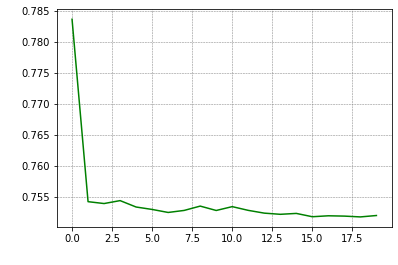

In [28]:
nn.set_epoch(20)
nn.set_sample(4000)
nn.train(train_data_set)
nn.set_sample(4000)
nn.train(test_data_set)